In [8]:
import os
from typing import TypedDict , Annotated , List
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph , END
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import create_tool_calling_agent , AgentExecutor

import os
from dotenv import load_dotenv

load_dotenv()

os.environ['TAVILY_API_KEY']  = os.getenv('TAVILY_API_KEY')
model = 'gemini-1.5-flash'
llm = ChatGoogleGenerativeAI(model = model , api_key = os.getenv('GOOGLE_API_KEY'))
search_tool = TavilySearchResults(max_results=5)

# print(llm.invoke('hi'))

class ResearchState(TypedDict):
    question:  str
    research_data: List[dict]
    draft: str


## creating research agent
research_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a research assistant. Analyze the user's question and determine what information needs to be gathered.
     Use the search tool to collect relevant data. Follow this format:
     
     Question: {input}
     Thought: {agent_scratchpad}"""),
    ("user", "{input}")
])

research_agent = create_tool_calling_agent(llm , [search_tool] , research_prompt)
research_executer = AgentExecutor(agent = research_agent , tools = [search_tool])


## Creating drafting agent
draft_prompt = ChatPromptTemplate.from_messages([
    ("system" , """ You are an expert writer. make a research data into a clear and give structured answer.
     Include all the key poits and relavent answer that are important"""),
    ('user' , """Original Question: {question}
     Research Data: {research_data}
     Create comprehensive answer: """)
])

draft_chain = draft_prompt | llm


## creating a function of research and draft to make node
def research_node(state: ResearchState):
    print(" Searching from Internet ---> ")
    result = research_executer.invoke({"input": state["question"]})
    return {"research_data": result["output"]}

def draft_node(state: ResearchState):
    print("drafting answer ---> ")
    result = draft_chain.invoke({
        "question": state["question"],
        "research_data": state["research_data"]
    })
    return {"draft": result.content}


### Graph building
workflow = StateGraph(ResearchState)
workflow.add_node("researcher", research_node)
workflow.add_node("drafter", draft_node)
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "drafter")
workflow.add_edge("drafter", END)
research_graph = workflow.compile()

### Graph
research_graph = workflow.compile() 

In [5]:
research_graph = workflow.compile()


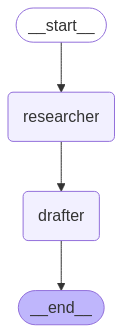

In [9]:
from IPython.display import Image, display

try:
    display(Image(research_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass